In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Mixed Gaussian distribution

2
(2, 1000)


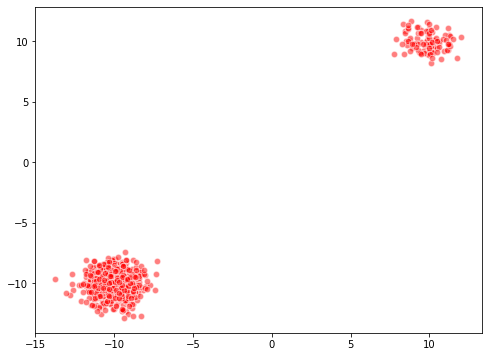

In [64]:
from numpy.random import multivariate_normal
from numpy.random import binomial

def make_mix_gauss(M, mean1, mean2, var1, var2, p):
    idx1 = binomial(1, p, M)
    idx2 = np.ones(M) - idx1

    data1 = multivariate_normal(mean1, np.diag(np.sqrt(var1)), M)
    data2 = multivariate_normal(mean2, np.diag(np.sqrt(var2)), M)

    gmm_data = np.diag(idx1) @ data1 + np.diag(idx2) @ data2
    return gmm_data


def sample_batch(M, mean1, mean2, var1, var2, p):
    x = make_mix_gauss(M, mean1, mean2, var1, var2, p)
    print(x.ndim)
    #return x[:, [0, 2]] / 10.0
    return x

mean1 = [10.0, 10.0]
mean2 = [-10.0, -10.0]
var1 = [0.5, 0.5]
var2 = [0.5, 0.5]
M = 10**3
p = 0.1
data = sample_batch(M, mean1, mean2, var1, var2, p).T
print(data.shape)
plt.figure(figsize=(8, 6))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

Funnel distribution

Ошибка cuda out of memory из-за больших значений x_i и y_i - найти способ их уменьшить

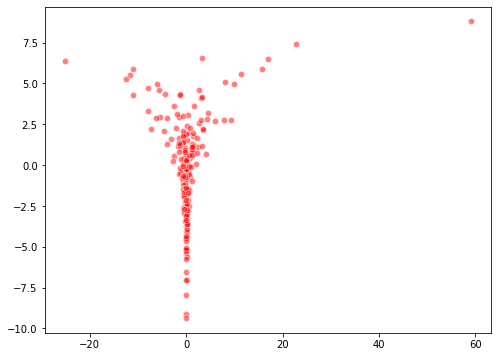

In [106]:
from numpy.random import normal
from math import exp 

#N = 1000
N = 200
y = normal(0, 3, N)
x = np.ones(N)
for i in range(len(x)):
    x[i] = normal(0, exp(y[i] / 2), 1)
x = x[:,np.newaxis]
y = y[:,np.newaxis]
data = np.concatenate((x,y), axis=1).T

plt.figure(figsize=(8, 6))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

Banana-shaped distribution

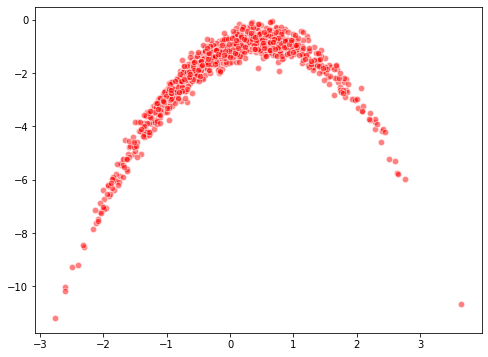

In [120]:
from numpy.random import multivariate_normal

N = 1000
mean = [0.0, 0.0]
cov = [[1.0, 0.95],
       [0.95, 1.0]]
x = multivariate_normal(mean, cov, N)
y1 = x[:, 0]
y2 = x[:, 1] - np.square(y1) - 1

y1 = y1[:,np.newaxis]
y2 = y2[:,np.newaxis]
data = np.concatenate((y1, y2), axis=1).T

plt.figure(figsize=(8, 6))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [121]:
print(torch.version.cuda)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

10.2
CUDA is available!  Training on GPU ...


In [6]:
DEVICE = torch.device("cuda")

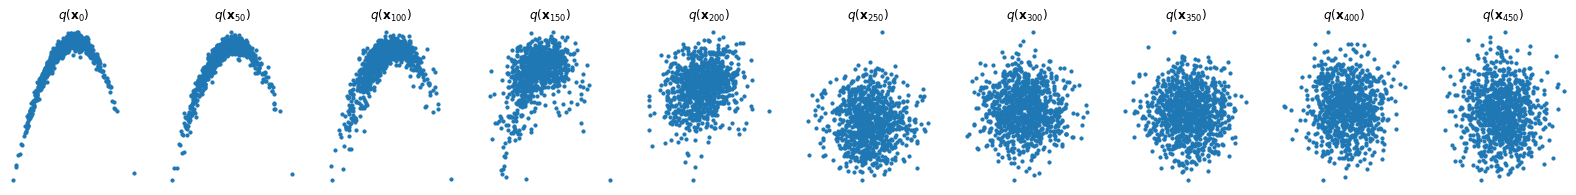

In [122]:
def forward_process(x_start, n_steps, noise=None):
    """ Diffuse the data (t == 0 means diffused for 1 step) """
    x_seq = [x_start]
    for n in range(n_steps):
        x_seq.append((torch.sqrt(1 - betas[n]) * x_seq[-1]) + (betas[n] * torch.rand_like(x_start)))
    return x_seq
n_steps = 500
#n_steps = 1000
betas = torch.tensor([0.035] * n_steps)
dataset = torch.Tensor(data.T).float()
x_seq = forward_process(dataset, n_steps, betas)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
#for i in range(10):
for i in range(10):    
    axs[i].scatter(x_seq[int((i / 10.0) * n_steps)][:, 0], x_seq[int((i / 10.0) * n_steps)][:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(int((i / 10.0) * n_steps))+'})$')

In [123]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas
    

In [124]:
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

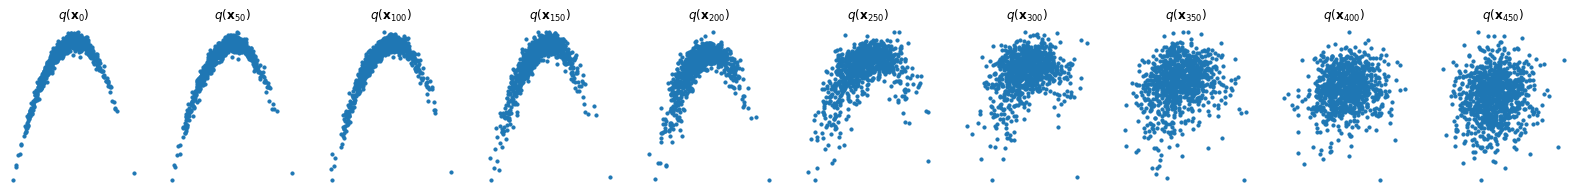

In [125]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_sample(dataset, torch.tensor([i * 50]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*50)+'})$')

In [126]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

In [127]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

DDPM

In [128]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

def p_sample(model, x, t):
    x = x.to(DEVICE)
    t = torch.tensor([t])
    t = t.to(DEVICE)
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    eps_factor = eps_factor.to(DEVICE)
    # Model output
    eps_theta = model(x, t)
    eps_theta = eps_theta.to(DEVICE)
    # Final values
    ex = extract(alphas, t, x).sqrt().to(DEVICE)
    mean = (1 / ex ) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    z = z.to(DEVICE)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sigma_t = sigma_t.to(DEVICE)
    sample = mean + sigma_t * z
    return (sample)

In [129]:
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

In [130]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    a = a.to(DEVICE)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    am1 = am1.to(DEVICE)
    e = torch.randn_like(x_0)
    e = e.to(DEVICE)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

In [131]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

In [132]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    cur_x = cur_x.to(DEVICE)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

tensor(1.0918, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5749, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7251, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5257, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4871, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5421, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5423, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4637, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4781, device='cuda:0', grad_fn=<MeanBackward0>)


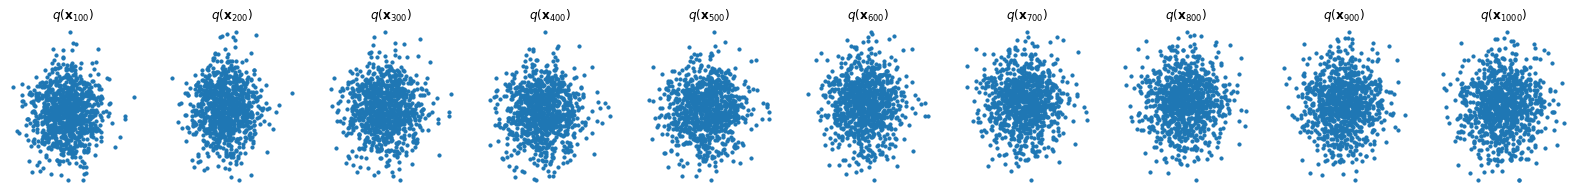

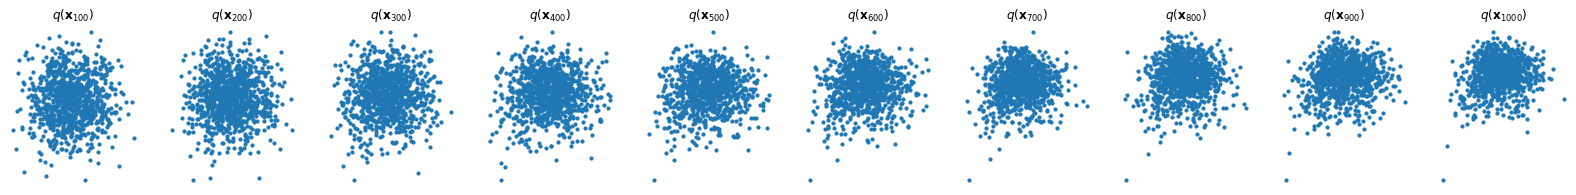

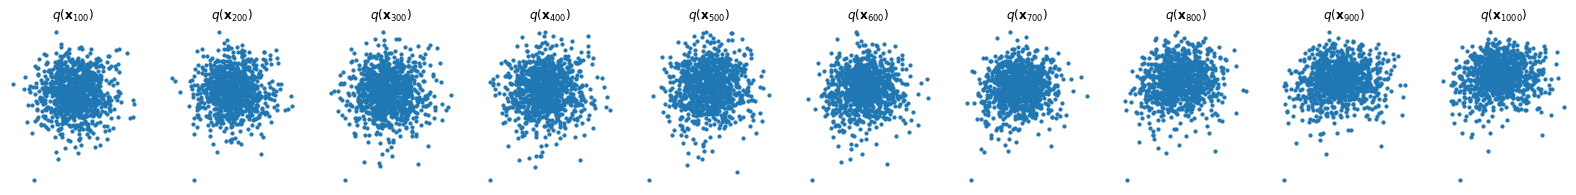

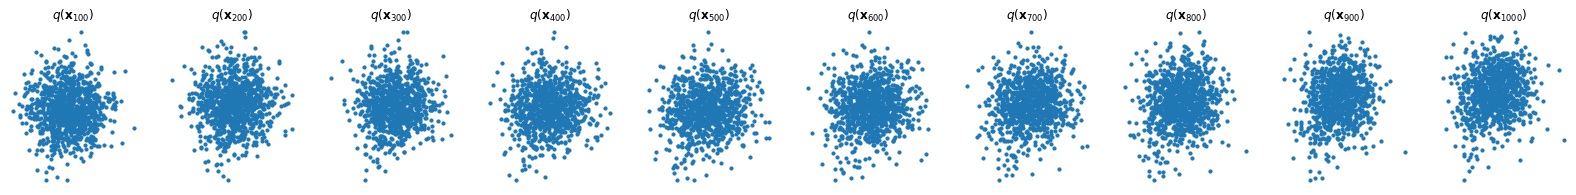

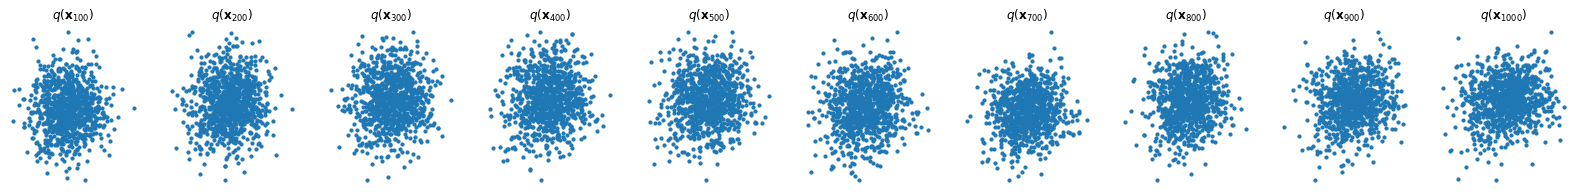

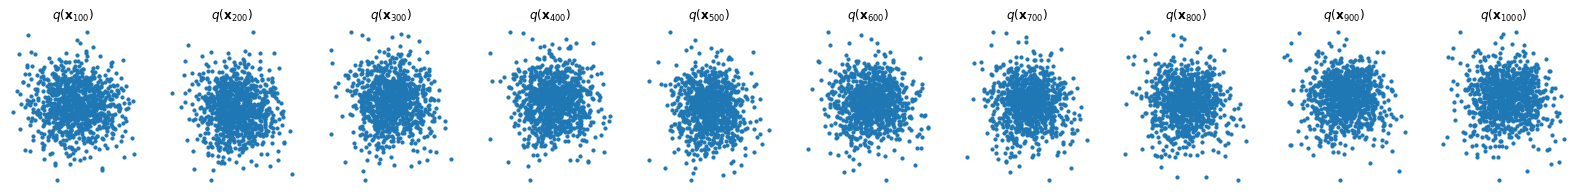

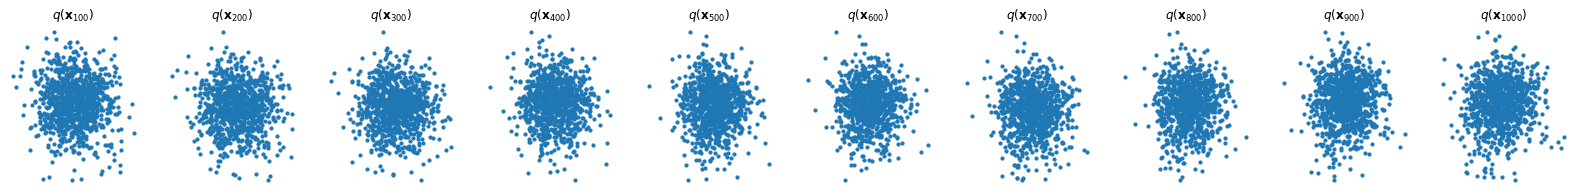

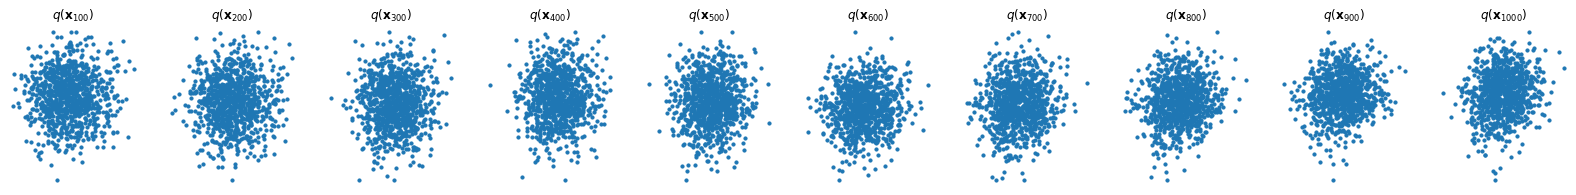

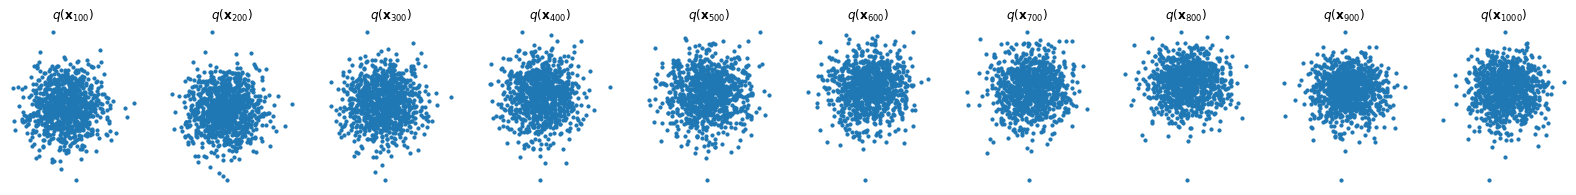

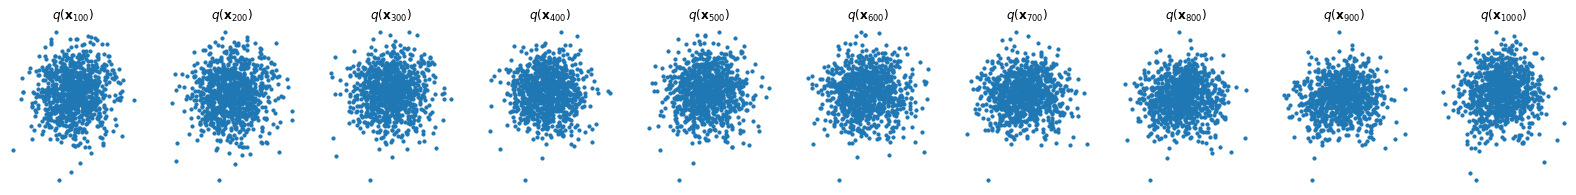

In [133]:
model = ConditionalModel(n_steps).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
#save losses for visualising training curve 
losses = []
#for t in range(1000):
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        batch_x = batch_x.to(DEVICE)
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    #if (t % 100 == 0):
    if (t % 10 == 0):
        losses.append(loss)
    
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach().cpu()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10)
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

Funnel, 5000 epochs, trained 20 min

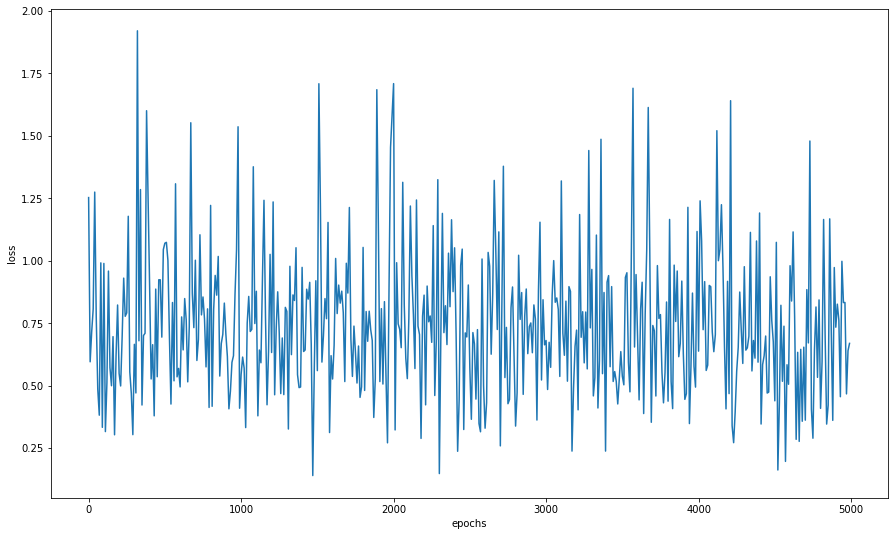

In [63]:
plt.figure(figsize=(15, 9))
np_losses = []
for item in losses:
    np_loss = item.cpu().detach().numpy()
    np_losses.append(np_loss)
#print(*np_losses)
epochs = [i for i in range(0,5000,10)]
plt.plot(epochs, np_losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Banana-shaped, 1000 epochs, вообще не учится(((

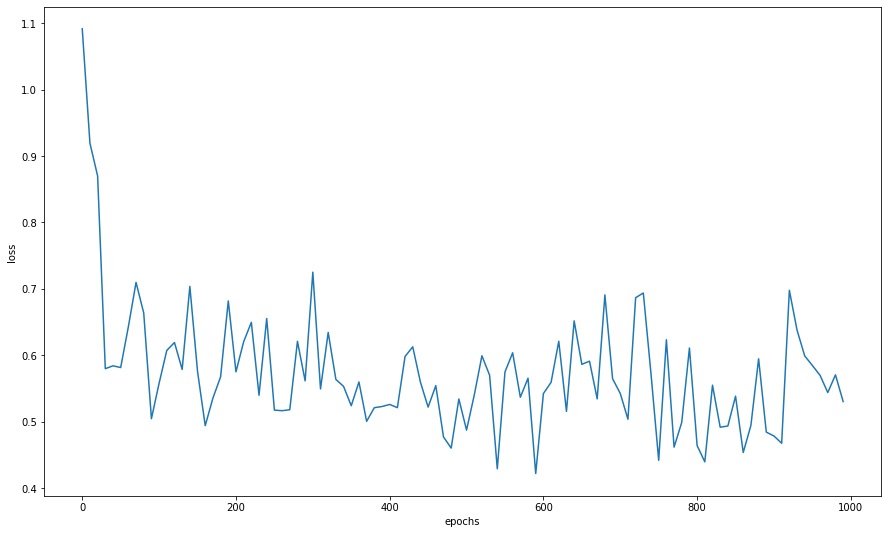

In [134]:
plt.figure(figsize=(15, 9))
np_losses = []
for item in losses:
    np_loss = item.cpu().detach().numpy()
    np_losses.append(np_loss)
#print(*np_losses)
epochs = [i for i in range(0,1000,10)]
plt.plot(epochs, np_losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()